In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.figure(figsize=(10, 6))
    
    if type(series) is tuple:
      for series_num in series:
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      plt.plot(time[start:end], series[start:end], format)

    plt.xlabel("Time")
    plt.ylabel("Valor")
    plt.grid(True)
    plt.show()

def trend(time, slope=0):
    series = slope * time
    return series

def seasonal_pattern(season_time):
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    data_pattern = amplitude * seasonal_pattern(season_time)
    return data_pattern

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    noise = rnd.randn(len(time)) * noise_level
    return noise


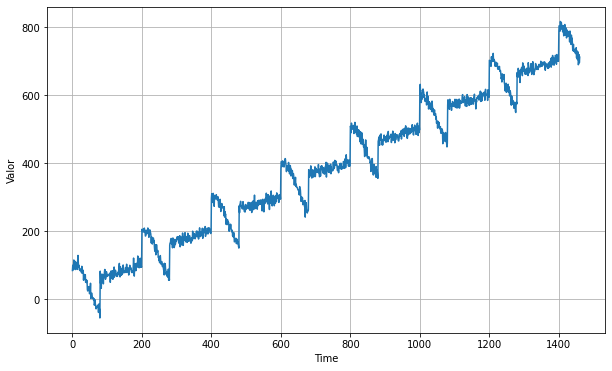

In [3]:
# Modificar parametros para cambiar la morfologia de la serie temporal
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 0
amplitude = 100
slope = 0.5
noise_level = 10

# Crear la serie
series = baseline + trend(time, slope) + seasonality(time, period=200, amplitude=amplitude)

# Agregar ruido
series += noise(time, noise_level, seed=50)

# Graficar la serie
plot_series(time, series)

In [4]:
#Separar datos de TRAIN y TEST

# muestra en la que se realiza el recorte
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]


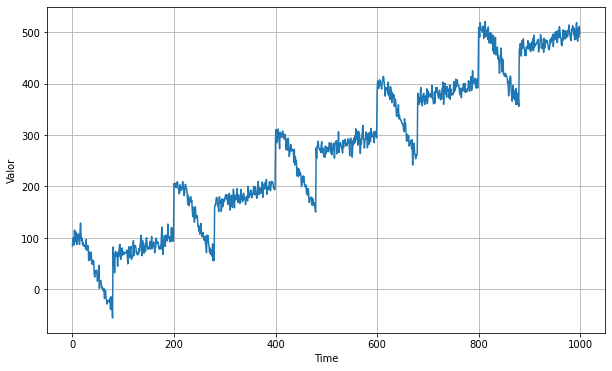

In [5]:
# Graficar la data de entrenamiento
plot_series(time_train, x_train)

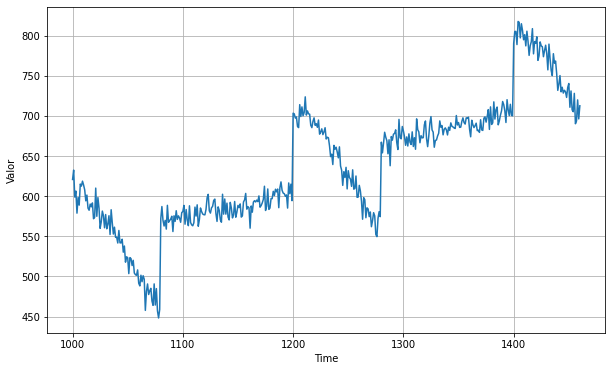

In [6]:
# Graficar la data de validación
plot_series(time_valid, x_valid)

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    dataset = tf.data.Dataset.from_tensor_slices(series) # Generamos un dataset de TF
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
   
    return dataset


In [8]:
# Definir parametros
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [10]:
# Definir modelos
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(100, input_shape=[window_size], activation='relu'),
                                    tf.keras.layers.Dense(10,  activation='relu'),
                                    tf.keras.layers.Dense(5,  activation='relu'),
                                    tf.keras.layers.Dense(1)])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2100      
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 3,171
Trainable params: 3,171
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 8s 184ms/step - loss: 93877.0703
Epoch 2/100
31/31 [==============================] - 1s 8ms/step - loss: 94870.6016
Epoch 3/100
31/31 [==============================] - 1s 9ms/step - loss: 94765.7109
Epoch 4/100
31/31 [==============================] - 1s 8ms/step - loss: 94662.9062
Epoch 5/100
31/31 [==============================] - 1s 9ms/step - loss: 94564.3906
Epoch 6/100
31/31 [==============================] - 1s 9ms/step - loss: 94466.6562
Epoch 7/100
31/31 [==============================] - 1s 7ms/step - loss: 94365.4609
Epoch 8/100
31/31 [==============================] - 1s 9ms/step - loss: 94259.3906
Epoch 9/100
31/31 [==============================] - 1s 7ms/step - loss: 94151.9766
Epoch 10/100
31/31 [==============================] - 1s 6ms/step - loss: 94033.2969
Epoch 11/100
31/31 [==============================] - 1s 8ms/step - loss: 93910.1484
Epoch 12/100
31/31 [==============================] - 1s 9ms/step - loss

In [12]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]

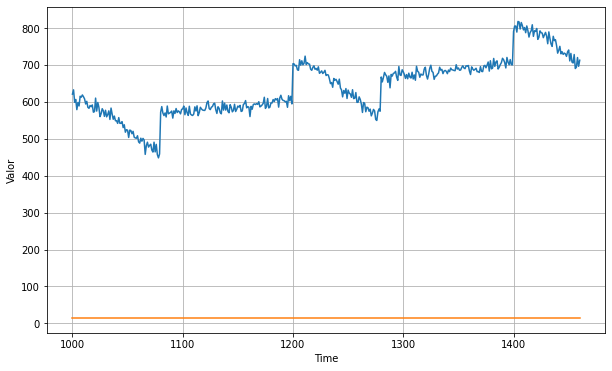

In [14]:
# Graficar serie + predicción
results = np.array(forecast).squeeze() #disminuimos dimensión
plot_series(time_valid, (x_valid, results))

In [15]:
import dvc

AttributeError: 'OutStream' object has no attribute '_exc'